# Dolsek and Fajfar

The aim of this procedure is the estimation of the median spectral acceleration value that brings the structure to the attainment of a set of damage states ds, and the corresponding dispersion. The aim is achieved making use of the work by [Dolsek and Fajfar (2004)](http://onlinelibrary.wiley.com/doi/10.1002/eqe.410/abstract) to estimate the inelastic displacement of a SDOF system based on its elastic displacement and the R-&mu;-T relationship proposed. Record-to-record dispersion from [Ruiz-García and Miranda (2007)](http://onlinelibrary.wiley.com/doi/10.1002/eqe.680/abstract) can be included in the derivation of fragility curves.

<img src="../../../../../figures/DF_r_mu_T.jpg" width="400" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [1]:
from rmtk.vulnerability.derivation_fragility.R_mu_T_no_dispersion.dolsek_fajfar import DF2004 
from rmtk.vulnerability.common import utils
%matplotlib inline

---
###Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of pushover curves, defined according to the format described in the [RMTK manual](../../../../../rmtk-docs.pdf). The user needs to provide the following information:
- The location of the folder containing the pushover curves using the parameter `capacity_curves_file`.
- The type of information provided in the input using the parameter `input_type`. The user can provide either base shear and top displacement ("Vb_droof") or base shear and displacement of each storey ("Vb_dfloor").
- A spectral shape file using the parameter `input_spectrum`, in case multiple pushover curves are input.

In [2]:
capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Vb-droof.csv'
input_type = 'Vb-dfloor'
input_spectrum = '../../../../../../rmtk_data/FEMAP965spectrum.txt'

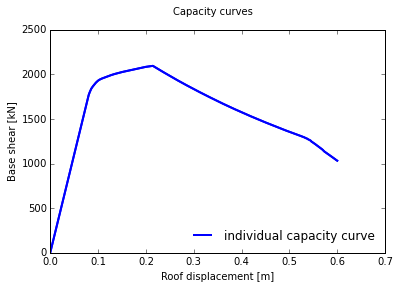

In [3]:
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
Sa_ratios = utils.get_spectral_ratios(capacity_curves,input_spectrum)

###Idealise pushover curves

In order to use this methodology the pushover curves need to be idealised.

Please choose an idealised shape using the parameter `idealised_type`. Valid options for this parameter are "bilinear" and "quadrilinear". Idealised curves can be directly provided as input setting the field 'Idealised' to TRUE in the input_file.

In [4]:
idealised_type = "bilinear"

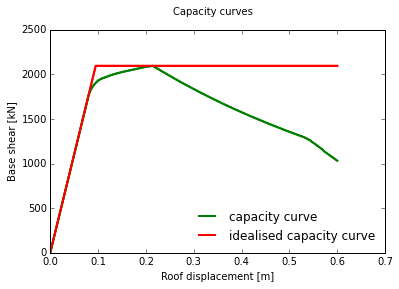

In [5]:
idealised_capacity = utils.idealisation(idealised_type, capacity_curves)
utils.plot_idealised_capacity(idealised_capacity, capacity_curves, idealised_type)

###Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

In [6]:
damage_model_file = "../../../../../../rmtk_data/damage_model_ISD.csv"

In [7]:
damage_model = utils.read_damage_model(damage_model_file)
print damage_model

{'dispersion': [[0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05]], 'type_criteria': 'interstorey drift', 'distribution': ['normal', 'normal', 'normal', 'normal'], 'median': [[0.005, 0.01, 0.02, 0.05], [0.005, 0.01, 0.02, 0.05]], 'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse']}


###Calculate fragility functions

The record-to-record dispersion and the damage threshold dispersion are calculated and integrated through Monte Carlo simulations. 

Please enter the number of Monte Carlo simulations to be performed using the parameter `montecarlo_samples`.

Please also define the constant acceleration-constant velocity and constant velocity-constant displacement corner periods of a Newmark-Hall type spectrum by setting the appropriate value for the parameter `corner_periods` in the cell below.

In [8]:
montecarlo_samples = 25
corner_periods = [0.5, 1.8]

In [9]:
fragility_model = DF2004.calculate_fragility(capacity_curves, idealised_capacity, damage_model, montecarlo_samples, Sa_ratios, corner_periods)

ac<0.02, it must be in [0.02,4], changed to ac = 0.02
mu(LS) =  [ 1.62898916  3.25797831  6.30729041  6.30729041]
medians= [ 0.1901851   0.38928813  0.75923524  0.75923524]
total dispersion= [ 0.21014769  0.3564222   0.3970612   0.39697751]


### Save fragility functions

The parameter `output_type` controls the choice of fragility function parameters that will be saved to disk. The three choices for this parameter are "median-dispersion", "logmean-cov", and "mean-sigma".

In [10]:
output_type = "logmean-cov"

In [11]:
utils.plot_fragility_model(fragility_model, 0.01, 2.0)
utils.create_fragility_out_files(fragility_model, output_type)

TypeError: list indices must be integers, not str